# Sentiment Based Product Recommendation System

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import python libraries
import numpy as np
from numpy import *
import pandas as pd
import re
import string
from collections import Counter
# Import Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Import NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud
# Import data imbalance libraries
from imblearn.over_sampling import SMOTE
# Import sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# Import Cosine and Adjusted Cosine similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Naive Bayes from sklearn
from sklearn.naive_bayes import MultinomialNB
# Importing Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# importing libraries for XGBoost classifier
from xgboost import XGBClassifier
# Import pickle to save and load the model
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Data sourcing

In [3]:
DRIVE_PATH="/content/drive/MyDrive/Colab Notebooks/"
# Data folder
DATA_DIRECTORY = DRIVE_PATH + "data/"

Load the data from the input file

In [4]:
df_original = pd.read_csv(DATA_DIRECTORY + "sample30.csv")

Print shape and first 5 rows

In [5]:
print(df_original.shape)
df_original.head(5)

(30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


### Exploratory Data Analysis

Start with Handling Null values

In [6]:
def MissingData(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    null_count = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=False)
    null_percentage = (
        df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]
    ).sort_values(ascending=False)
    null_data = pd.concat([null_count, null_percentage], axis=1, keys=["Count", "Percentage"])
    return null_data

In [7]:
MissingData(df_original)

,Count,Percentage
reviews_userProvince,29830,99.433333
reviews_userCity,28071,93.570000
reviews_didPurchase,14068,46.893333
reviews_doRecommend,2570,8.566667
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


reviews_userProvince and reviews_userCity have over 93% NULL values and are not useful for analysis. We will remove them from the dataset.<br>
reviews_didPurchase column has over 46% NULL values. This field is not useful in building either Sentiment/Recommender system as well and will be removed.<br>
copy the original data frame to another df

In [8]:
df_clean = df_original.copy()
df_clean.drop(
    columns=["reviews_userProvince", "reviews_userCity", "reviews_didPurchase"], inplace=True
)

Check for missing data again

In [9]:
MissingData(df_clean)

,Count,Percentage
reviews_doRecommend,2570,8.566667
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


Check column reviews_DoRecommend

In [10]:
df_clean.reviews_doRecommend.value_counts(normalize=True)
# can delete this column as it makes no sense to keep a column with 94% true data
df_clean.drop(columns=["reviews_doRecommend"], inplace=True)

Check for missing data again

In [11]:
MissingData(df_clean)

,Count,Percentage
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


Reviews Title is a critical feature for the sentiment classification model and since the null data is less 0.63% it makes sense to remove these records from the data frame<br>
Checking rowcount before deletion

In [12]:
df_clean.shape
df_clean = df_clean[~df_clean.reviews_title.isna()]
df_clean.shape

(29810, 11)

Check for missing data again

In [13]:
MissingData(df_clean)

,Count,Percentage
manufacturer,141,0.472996
reviews_username,62,0.207984
reviews_date,46,0.154311
user_sentiment,1,0.003355


Reviews UserName is a critical feature for the recommendation model and since the null data is less 0.20% it makes sense to remove these records from the data frame<br>
Checking rowcount before deletion

In [14]:
df_clean.shape
df_clean = df_clean[~df_clean.reviews_username.isna()]
df_clean.shape

(29748, 11)

Check for missing data again

In [15]:
MissingData(df_clean)

,Count,Percentage
manufacturer,141,0.473981
reviews_date,40,0.134463
user_sentiment,1,0.003362


Check column reviews_date

In [16]:
df_clean.reviews_date.value_counts(normalize=True)

2012-01-26T00:00:00.000Z    0.035041
2014-12-03T00:00:00.000Z    0.017638
2014-09-19T00:00:00.000Z    0.013666
2014-12-05T00:00:00.000Z    0.011613
2014-12-04T00:00:00.000Z    0.010132
                              ...   
2014-12-04T05:21:24.000Z    0.000034
2014-12-04T00:40:50.000Z    0.000034
2014-12-04T17:01:41.000Z    0.000034
2014-12-03T23:00:35.000Z    0.000034
2017-08-04T15:01:04.000Z    0.000034
Name: reviews_date, Length: 6670, dtype: float64

In [17]:
# can delete this column as we will not need the review date for either classification or recommendation engine
df_clean.drop(columns=["reviews_date"], inplace=True)

Check for missing data again

In [18]:
MissingData(df_clean)

,Count,Percentage
manufacturer,141,0.473981
user_sentiment,1,0.003362


As there is only one record with missing data for user_sentiment, we will read the record manually and update the value.

In [19]:
df_clean[df_clean.user_sentiment.isna()]
# overall from the values the sentiment seems Positive and we will update accordingly
df_clean.user_sentiment.fillna("Positive", inplace=True)

Check for missing data again

In [20]:
MissingData(df_clean)

,Count,Percentage
manufacturer,141,0.473981


Can delete the column manufacturer as we will not need the manufacturer value for classification or recommendation engine

In [21]:
df_clean.drop(columns=["manufacturer"], inplace=True)

Check for missing data again

In [22]:
MissingData(df_clean)

,Count,Percentage


In [23]:
df_clean.shape

(29748, 9)

Null values are fully taken care now, and after that final shape of dataset is 29748 rows and 9 columns

Analyze the user_sentiment column

<Axes: xlabel='user_sentiment', ylabel='count'>

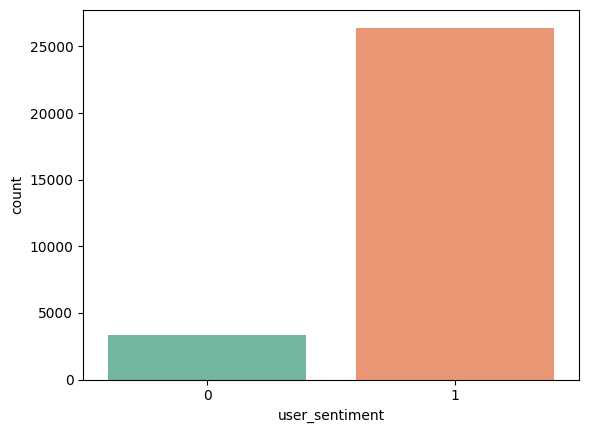

In [24]:
# Map the categorical user_sentiment to numerical 1 or 0 for Classification Model
df_clean["user_sentiment"] = df_clean["user_sentiment"].map({"Positive": 1, "Negative": 0})
# get the value count of user_sentiments column
df_clean["user_sentiment"].value_counts(normalize=True)
# Visualize using count plot
sns.countplot(x="user_sentiment", data=df_clean, palette="Set2")

We can see in user sentiment that positive reviews are way higher than negative causing imbalance. we may have to do Class Imbalance techniques during modelling.

Analyze the reviews_rating column

In [114]:
df_clean["reviews_rating"].value_counts(normalize=True)

5    0.694299
4    0.201425
1    0.045751
3    0.044776
2    0.013749
Name: reviews_rating, dtype: float64

Almost 90% of reviews have rating of 4 and above. 69.5% of the reviews have rating of 5.

<Axes: xlabel='reviews_rating', ylabel='count'>

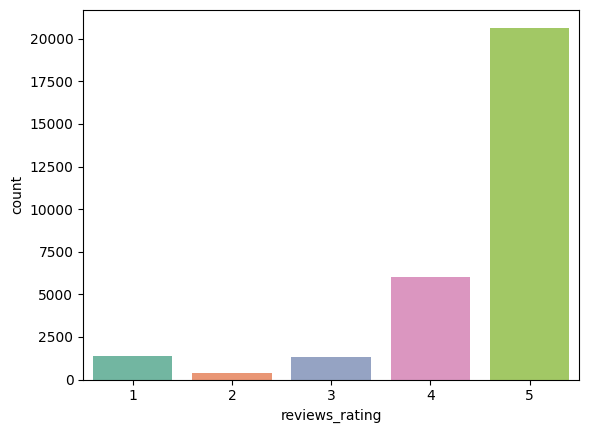

In [25]:
# visualize the reviews_rating.
sns.countplot(x="reviews_rating", data=df_clean, palette="Set2")

Analyze the Reviews_Rating and user_sentiment for corelation analysis

Check the ratings for positive sentiment records

In [26]:
df_clean[df_clean["user_sentiment"] == 1]["reviews_rating"].describe()

count    26413.000000
mean         4.561049
std          0.863175
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

Check the ratings for negative sentiment records

In [27]:
df_clean[df_clean["user_sentiment"] == 0]["reviews_rating"].describe()
# seems to be an issue with data as the 50% of records have rating 5 for negative sentiment reviews and calls for detailed analysis
# analyse the actual title and reviews for such ambigous records
df_clean[(df_clean["user_sentiment"] == 1) & (df_clean["reviews_rating"] < 4)][
    ["reviews_title", "reviews_text"]
]
df_clean[(df_clean["user_sentiment"] == 0) & (df_clean["reviews_rating"] >= 4)][
    ["reviews_title", "reviews_text"]
]
pd.crosstab(df_clean["user_sentiment"], df_clean["reviews_rating"], margins=True)
# As per the above results, there looks to be mismtach between review_rating and user_sentiment
# There are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive.
# We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling.
# Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4
df_clean.loc[
    (df_clean["user_sentiment"] == 1) & (df_clean["reviews_rating"] < 4), "user_sentiment"
] = 0
df_clean.loc[
    (df_clean["user_sentiment"] == 0) & (df_clean["reviews_rating"] >= 4), "user_sentiment"
] = 1
pd.crosstab(df_clean["user_sentiment"], df_clean["reviews_rating"], margins=True)
# from the above cross table, we can see that we don't have mismatch anymore between the reviews_rating and user_sentiment
df_clean["user_sentiment"].value_counts()
# Still imbalance in the data with higher positive reviews 26646 as positive and 3102 as negative

1    26646
0     3102
Name: user_sentiment, dtype: int64

Analyze the brand column

In [116]:
df_clean["brand"].value_counts()
# Clorox, Warner home video, Disney, Loreal and Fox are the top 5 brands

Clorox                   10564
Warner Home Video         3324
Disney                    1197
L'oreal Paris             1186
FOX                        887
                         ...  
JNH Lifestyles               1
Teamson                      1
Rizzy Home                   1
Pacific Natural Foods        1
Mill Creek                   1
Name: brand, Length: 199, dtype: int64

Filter the top 10 brands among the positive sentiments

<Axes: xlabel='brand'>

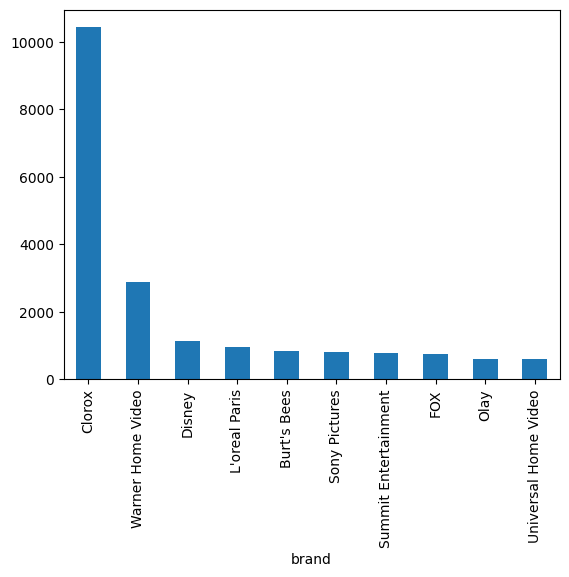

In [28]:
df_clean[df_clean["user_sentiment"] == 1].groupby("brand")["brand"].count().sort_values(
    ascending=False
).head(10).plot(kind="bar")

Filter the top 10 brands among the negative sentiments

<Axes: xlabel='brand'>

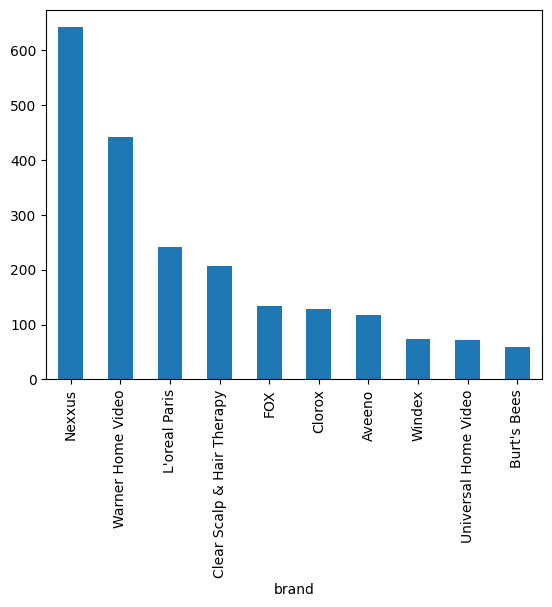

In [29]:
df_clean[df_clean["user_sentiment"] == 0].groupby("brand")["brand"].count().sort_values(
    ascending=False
).head(10).plot(kind="bar")

Analyze the reviews_username column

In [30]:
df_clean["reviews_username"].value_counts()

mike                 41
byamazon customer    41
chris                31
rick                 15
sandy                15
                     ..
monlew26              1
mountainqueen6        1
chrystal85            1
jredd001              1
kcoopxoxo             1
Name: reviews_username, Length: 24788, dtype: int64

Overall distribution looks OK and there is a long tail of user vs product rating

List the top 10 customers by 'positive user sentiment'

In [31]:
df_clean[df_clean["user_sentiment"] == 1].groupby("reviews_username")[
    "reviews_username"
].count().sort_values(ascending=False)[:10]

reviews_username
mike                 36
byamazon customer    31
chris                28
jojo                 13
sandy                13
rick                 13
john                 13
tony                 13
movielover           12
james                12
Name: reviews_username, dtype: int64

List the top 10 customers by 'negative user sentiment'

In [32]:
df_clean[df_clean["user_sentiment"] == 0].groupby("reviews_username")[
    "reviews_username"
].count().sort_values(ascending=False)[:10]

reviews_username
byamazon customer    10
mike                  5
disappointed          5
kevman79              4
mark                  4
jill                  4
island girl           4
cool                  4
chris                 3
rachael               3
Name: reviews_username, dtype: int64

#### Feature Standardization

Before we start the pre-processing steps, we need to make sure that all the text columns are converted to string type for future text operations.

In [33]:
df_clean["brand"] = df_clean["brand"].astype(str)
df_clean["categories"] = df_clean["categories"].astype(str)
df_clean["name"] = df_clean["name"].astype(str)
df_clean["reviews_text"] = df_clean["reviews_text"].astype(str)
df_clean["reviews_title"] = df_clean["reviews_title"].astype(str)
df_clean["reviews_username"] = df_clean["reviews_username"].astype(str)

Since we want on feature for the reviews let us combine the title and reviews

In [34]:
df_clean["reviews_title"] = df_clean["reviews_title"].fillna("")
df_clean["reviews_full_text"] = (
    df_clean[["reviews_title", "reviews_text"]].agg(". ".join, axis=1).str.lstrip(". ")
)
df_clean.reviews_full_text.head(10)

0    Just Awesome. i love this album. it's very goo...
1    Good. Good flavor. This review was collected a...
2                                   Good. Good flavor.
3    Disappointed. I read through the reviews on he...
4    Irritation. My husband bought this gel for us....
5    Not worth it. My boyfriend and I bought this t...
6    Disappointing. Bought this earlier today and w...
7    Not happy at all. I bought this product for my...
8    Very disappointing. My husband and I bought th...
9    Don't buy. Got as a surprise for my husband th...
Name: reviews_full_text, dtype: object

Check for missing data again

In [35]:
MissingData(df_clean)
# No Missing data present now

,Count,Percentage


Keep the df_clean intact for later use for recommendation and filtering

For now lets create a Df for sentiment classification model

The above data source is final and can be used for modeling - classification and recommendation

Create data frame for classification model

In [36]:
df_classification = df_clean[["id", "name", "reviews_full_text", "user_sentiment"]]

In [37]:
df_classification.head(4)

,id,name,reviews_full_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very goo...,1
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected a...,1
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Disappointed. I read through the reviews on he...,0


In [38]:
df_classification.shape
# 29748 rows and 4 columns

(29748, 4)

### Text PreProcessing

NLP Text Preprocessing for the classification modelling<br>
Create functions for different NLP tasks for the review text data

Function to clean the text and remove all the unnecessary elements.

In [39]:
def remove_punctuations(sentence):
    sentence = sentence.lower()  # Text to lowercase
    sentence = sentence.strip()  # strip the extra spaces
    pattern = "[^\w\s]"  # Removing punctuation
    sentence = re.sub(pattern, "", sentence)
    return sentence

Function to remove the stop words.

In [40]:
stop_words = set(stopwords.words("english"))

In [41]:
def remove_stopwords(sentence):
    words = [word for word in sentence.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

Function to do lemmatization of the tokens

In [42]:
lemmatizer = WordNetLemmatizer()

This is a helper function to map NTLK position tags

In [43]:
def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Lemmatization function

In [44]:
def lemma_text(sentence):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopwords(sentence)))  # Get position tags
    # Map the position tag and lemmatize the word/token
    words = [
        lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1]))
        for idx, tag in enumerate(word_pos_tags)
    ]
    return " ".join(words)

Apply the various functions created above to create the model data frame

In [45]:
df_classification["reviews_full_text_cleaned"] = df_classification.reviews_full_text.apply(
    lambda x: remove_punctuations(x)
)
df_classification["reviews_full_text_cleaned"].head(5)

0    just awesome i love this album its very good m...
1    good good flavor this review was collected as ...
2                                     good good flavor
3    disappointed i read through the reviews on her...
4    irritation my husband bought this gel for us t...
Name: reviews_full_text_cleaned, dtype: object

In [46]:
df_classification["reviews_full_text_lemma"] = df_classification.reviews_full_text_cleaned.apply(
    lambda x: lemma_text(x)
)
df_classification["reviews_full_text_lemma"].head(5)

0    awesome love album good hip hop side current p...
1       good good flavor review collect part promotion
2                                     good good flavor
3    disappoint read review look buy one couple lub...
4    irritation husband buy gel u gel caused irrita...
Name: reviews_full_text_lemma, dtype: object

Build a word cloud to find the top 25 words by frequency among all the reviews after processing the text

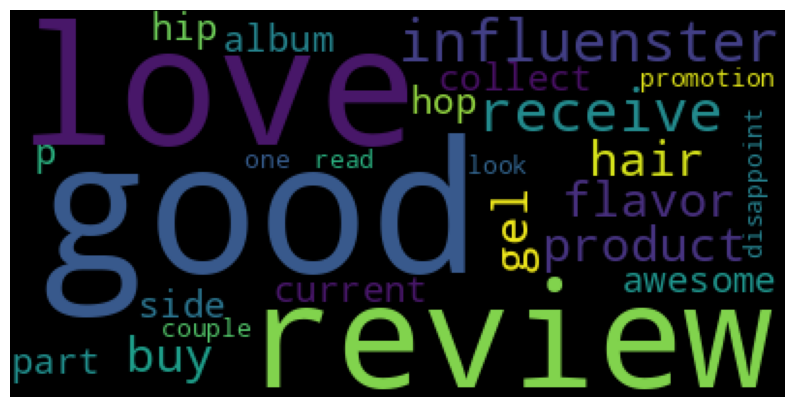

In [47]:
wordcloud = WordCloud(stopwords=stop_words, max_words=25).generate(
    str(df_classification.reviews_full_text_lemma)
)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Function to get the most common words from the feature

In [48]:
def getMostCommonWords(reviews, n_most_common):
    # flatten lemma review column into a list of words, and set to lowercase
    flattened_reviews = [word for review in reviews for word in review.lower().split()]
    # remove punctuation from reviews
    flattened_reviews = [
        "".join(char for char in review if char not in string.punctuation)
        for review in flattened_reviews
    ]
    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]
    return Counter(flattened_reviews).most_common(n_most_common)

Get 15 common words for positive reviews

In [49]:
pos_reviews = df_classification[df_classification["user_sentiment"] == 1]
getMostCommonWords(pos_reviews["reviews_full_text_lemma"], 15)

[('great', 14349),
 ('love', 12402),
 ('use', 11680),
 ('product', 10749),
 ('movie', 9850),
 ('review', 8879),
 ('part', 8722),
 ('promotion', 8374),
 ('wipe', 8189),
 ('clean', 8067),
 ('collect', 7943),
 ('good', 6196),
 ('clorox', 5955),
 ('easy', 4180),
 ('like', 4081)]

Get 15 common words for negative reviews

In [50]:
neg_reviews = df_classification[df_classification["user_sentiment"] == 0]
getMostCommonWords(neg_reviews["reviews_full_text_lemma"], 15)

[('product', 1915),
 ('use', 1779),
 ('hair', 1544),
 ('formula', 1439),
 ('new', 1260),
 ('old', 1078),
 ('good', 1073),
 ('like', 1070),
 ('movie', 1032),
 ('gel', 874),
 ('back', 870),
 ('smell', 815),
 ('would', 685),
 ('change', 666),
 ('get', 642)]

Create a function to get the ngrams frequency of the reviews

In [51]:
def get_top_n_ngram(corpus, n_gram_range, n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words="english").fit(
        corpus
    )
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

Print the top 10 bigrams for positive reviews

In [52]:
common_words = get_top_n_ngram(pos_reviews["reviews_full_text_lemma"], 2, 10)
pd.DataFrame(common_words)

,0,1
0,review collect,7920
1,collect promotion,7920
2,clorox wipe,2803
3,great product,1942
4,great movie,1739
5,easy use,1552
6,love clorox,1223
7,love product,1135
8,use clorox,1088
9,good movie,922


Print the top 10 bigrams for negative reviews

In [53]:
common_words = get_top_n_ngram(neg_reviews["reviews_full_text_lemma"], 2, 10)
pd.DataFrame(common_words)

,0,1
0,new formula,520
1,old formula,515
2,bring old,369
3,review collect,345
4,collect promotion,345
5,exxtra gel,205
6,use product,180
7,make hair,156
8,shampoo conditioner,147
9,gel year,127


Print the top 10 trigrams for positive reviews

In [54]:
common_words = get_top_n_ngram(pos_reviews["reviews_full_text_lemma"], 3, 10)
pd.DataFrame(common_words)

,0,1
0,review collect promotion,7920
1,love clorox wipe,601
2,use clorox wipe,550
3,clorox disinfect wipe,548
4,review collected promotion,452
5,clean review collect,426
6,use review collect,351
7,product review collect,342
8,great product love,288
9,great movie great,268


Print the top 10 trigrams for negative reviews

In [55]:
common_words = get_top_n_ngram(neg_reviews["reviews_full_text_lemma"], 3, 10)
pd.DataFrame(common_words)

,0,1
0,review collect promotion,345
1,bring old formula,237
2,use product year,81
3,opinion review collect,63
4,nexxus exxtra gel,62
5,receive product free,59
6,exxtra gel year,44
7,use gel year,43
8,use old formula,42
9,testing purpose opinion,38


### Feature Extraction

Initialize the TfidfVectorizer max features 650<br>
max_df = 0.95 means ignore terms that appear in more than 95% of the reviews<br>
min_df = 5 means ignore terms that appear in less than 5 reviews<br>
ngram range of 2

In [56]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english", max_features=650, max_df=0.9, min_df=5, binary=True, ngram_range=(1, 2)
)

Create X and y variables

In [57]:
X = tfidf_vectorizer.fit_transform(df_classification["reviews_full_text_lemma"])
y = df_classification["user_sentiment"]

Create train test split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22311, 650) (22311,)
Test shapes: (7437, 650) (7437,)


Handling class imbalance in the dataset

In [59]:
df_classification.user_sentiment.value_counts(normalize=True)

1    0.895724
0    0.104276
Name: user_sentiment, dtype: float64

89.5% positive reviews and 10.5% negative reviews which means big class imbalance

Apply SMOTE technique to balance the dataset

SMOTE - oversampling method that generates synthetic samples for the minority class

In [60]:
print("Before doing SMOTE", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("After doing SMOTE", Counter(y_train_sm))


Before doing SMOTE Counter({1: 19967, 0: 2344})
After doing SMOTE Counter({1: 19967, 0: 19967})


Perfect balance now post SMOTE for positive and negative sentiment reviews

### Model Building: Sentiment Classification

Define functions for model training, model evaluation, confusion matrix

In [61]:
class ModelBuilder:
    # initialization constructor
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    # function to train the model and return predictions
    def train_model(self):
        self.model.fit(self.x_train, self.y_train)
        return self.model.predict(self.x_test)

    # function to evaluate the model and see confusion matrix and ROC curve
    def evaluate_model(self, y_pred_class):
        print("*" * 50)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*" * 50)
        self.classification_report(y_pred_class)
        print("*" * 50)
        self.confusion_matrix(y_pred_class)
        print("*" * 50)
        # print("\n")

        # metrics.plot_roc_curve(self.model, self.x_test, self.y_test)
        metrics.RocCurveDisplay.from_estimator(self.model, X_test, y_test)
        return self.result_metrics

    # function to generate model evaluation metrics like accuracy and f1 score etc
    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:, 1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)
        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix, [0, 1])

    # function to plot the confusion matrix
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data / np.sum(data), annot=True, cmap="Blues", fmt=".2%")
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    # function to generate the ootb classification report from the metrics class
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

#### Build different Models to evaluate model statistics
#### Logistic Regression Model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
**************************************************
Accuracy is : 87.4%
Precision is : 96.9%
Recall is : 88.8%
F1 Score is : 92.7%
Roc-Auc Score is:90.2%
**************************************************
              precision    recall  f1-score   support

           0       0.43      0.75      0.55       758
           1       0.97      0.89      0.93      6679

    accuracy                           0.87      7437
   macro avg       0.70      0.82      0.74      7437
weighted avg       0.91      0.87      0.89      7437

**************************************************


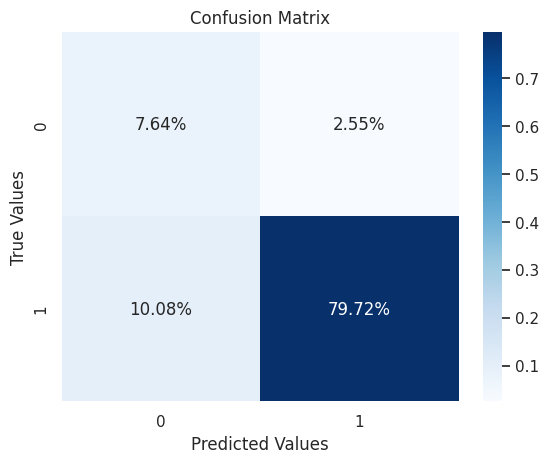

**************************************************


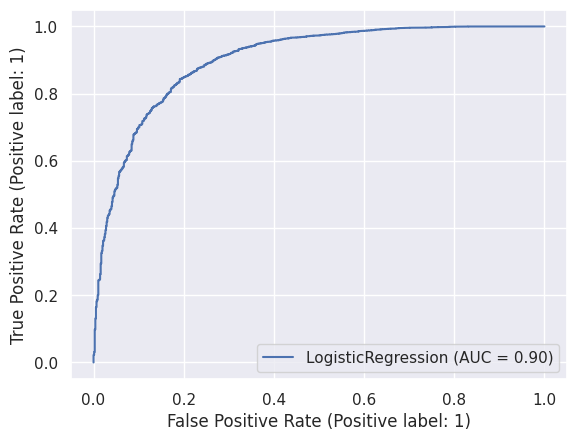

In [62]:
%time
logreg_model = LogisticRegression(random_state=42, max_iter=100, solver="liblinear")
logistic_modelbuilder = ModelBuilder(logreg_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class = logistic_modelbuilder.train_model()
lr_metrics = logistic_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the base logistic regression model is good with 92.7%

#### Naive Bayes Model

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs
**************************************************
Accuracy is : 80.3%
Precision is : 97.6%
Recall is : 80.0%
F1 Score is : 87.9%
Roc-Auc Score is:89.4%
**************************************************
              precision    recall  f1-score   support

           0       0.32      0.83      0.46       758
           1       0.98      0.80      0.88      6679

    accuracy                           0.80      7437
   macro avg       0.65      0.81      0.67      7437
weighted avg       0.91      0.80      0.84      7437

**************************************************


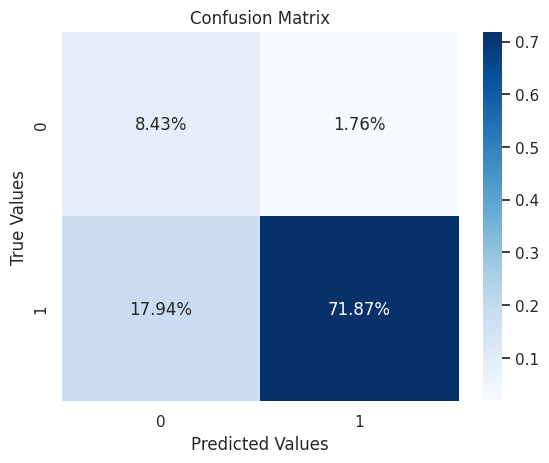

**************************************************


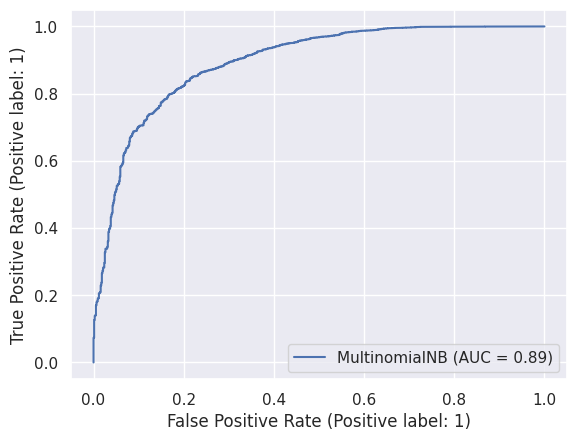

In [63]:
%time
mnb_model = MultinomialNB(alpha=1.0)
mnb_modelbuilder = ModelBuilder(mnb_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class = mnb_modelbuilder.train_model()
mnb_metrics = mnb_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the base Naive Bayes model is good with 87.9% F1 score. So LR model better than NB model so far for the base model

#### Decision Tree Model

**************************************************
Accuracy is : 82.2%
Precision is : 95.9%
Recall is : 83.8%
F1 Score is : 89.4%
Roc-Auc Score is:82.5%
**************************************************
              precision    recall  f1-score   support

           0       0.32      0.68      0.44       758
           1       0.96      0.84      0.89      6679

    accuracy                           0.82      7437
   macro avg       0.64      0.76      0.67      7437
weighted avg       0.89      0.82      0.85      7437

**************************************************


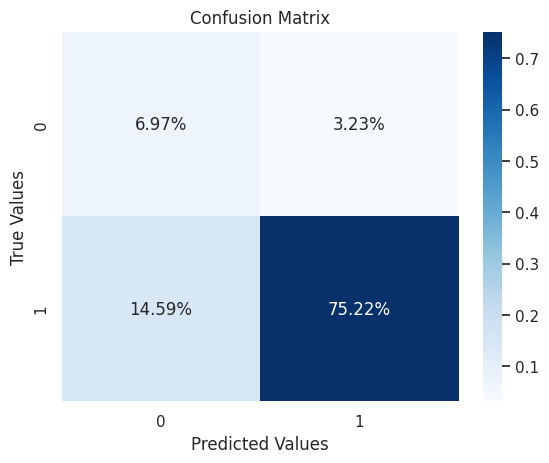

**************************************************


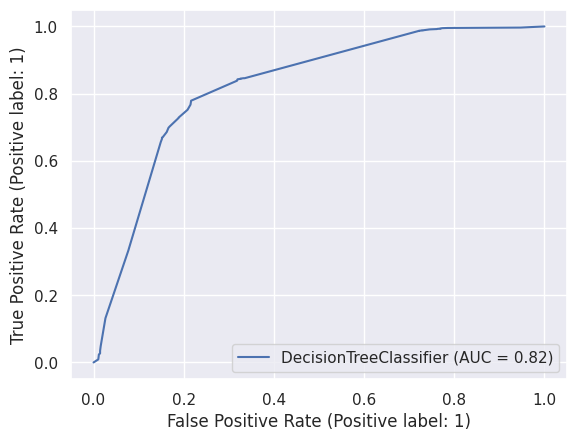

In [64]:
dt_model = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)
dt_modelbuilder = ModelBuilder(dt_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the decision tree model is good with 89.4%.

#### Random Forest Model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Fitting 4 folds for each of 64 candidates, totalling 256 fits
**************************************************
Accuracy is : 79.3%
Precision is : 96.8%
Recall is : 79.6%
F1 Score is : 87.4%
Roc-Auc Score is:86.2%
**************************************************
              precision    recall  f1-score   support

           0       0.30      0.77      0.43       758
           1       0.97      0.80      0.87      6679

    accuracy                           0.79      7437
   macro avg       0.63      0.78      0.65      7437
weighted avg       0.90      0.79      0.83      7437

**************************************************


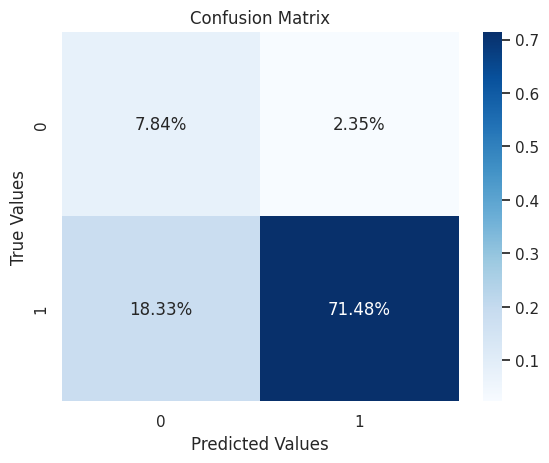

**************************************************


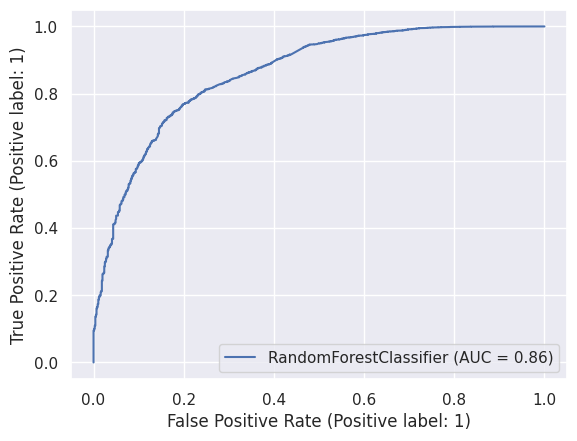

In [65]:
rf_model = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")
params = {
    "max_depth": [2, 3, 5, 10],
    "min_samples_leaf": [5, 10, 20, 50],
    "n_estimators": [10, 25, 50, 100],
}
grid_search = GridSearchCV(
    estimator=rf_model, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring="f1"
)
%time
grid_search.fit(X_train_sm, y_train_sm)
rf_best_model = grid_search.best_estimator_
rf_modelbuilder = ModelBuilder(rf_best_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class = rf_modelbuilder.train_model()
rf_metrics = rf_modelbuilder.evaluate_model(y_pred_class)
# F1 Accuracy for the Random Forest model is 87.36%

#### XGBoost Model

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs
**************************************************
Accuracy is : 90.4%
Precision is : 96.1%
Recall is : 93.2%
F1 Score is : 94.6%
Roc-Auc Score is:90.5%
**************************************************
              precision    recall  f1-score   support

           0       0.52      0.66      0.59       758
           1       0.96      0.93      0.95      6679

    accuracy                           0.90      7437
   macro avg       0.74      0.80      0.77      7437
weighted avg       0.92      0.90      0.91      7437

**************************************************


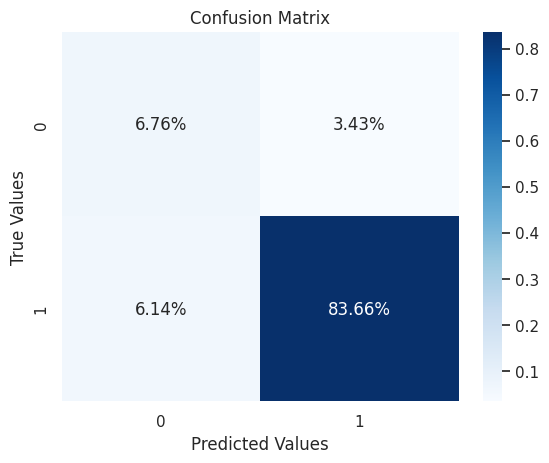

**************************************************


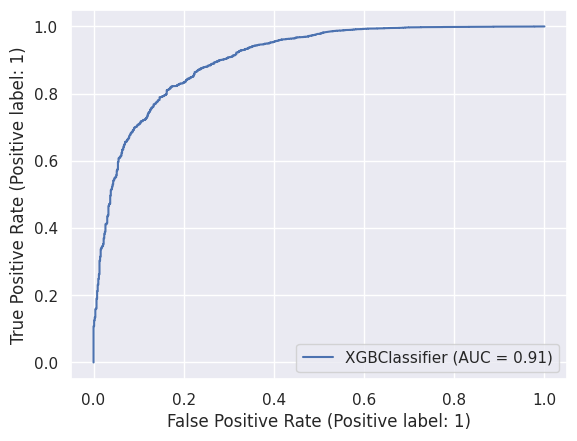

In [66]:
%time
xgbclf_model = XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42)
xgb_modelbuilder = ModelBuilder(xgbclf_model, X_train_sm, X_test, y_train_sm, y_test)
# Train and Predict the Test Labels
y_pred_class = xgb_modelbuilder.train_model()
xg_metrics = xgb_modelbuilder.evaluate_model(y_pred_class)
# F1 accuracy for the XGBoost classifier model is 94.58%

#### Model Evaluation and selection

Creating a data frame to store all the accuracy metrics of all the 4 models built for side by side comparison and choosing the best model out of 4

In [67]:
modelmetrics_datatable = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1Score", "Auc Score"],
    "Logistic Regression": lr_metrics,
    "Naive Bayes": mnb_metrics,
    "Decision Tree": dt_metrics_cv,
    "Random Forest": rf_metrics,
    "XG Boost": xg_metrics,
}

In [68]:
df_model_metrics = pd.DataFrame(
    modelmetrics_datatable,
    columns=[
        "Metric",
        "Logistic Regression",
        "Naive Bayes",
        "Decision Tree",
        "Random Forest",
        "XG Boost",
    ],
)
df_model_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forest,XG Boost
0,Accuracy,0.873605,0.803012,0.821837,0.793196,0.904262
1,Precision,0.968949,0.976077,0.958862,0.968130,0.960630
2,Recall,0.887708,0.800270,0.837551,0.795928,0.931577
3,F1Score,0.926551,0.879473,0.894110,0.873624,0.945880
4,Auc Score,0.902023,0.894022,0.824787,0.862437,0.905309


On the comparison of the 5 models, XGboost classifier model has the highest metrics for f1 score (balance of precision and recall) and AUC score.

In [69]:
# Pickle saved files directory
ML_MODELS_DIRECTORY = DRIVE_PATH + "model_files/"

# Data model object filenames
SENTIMENT_CLASSIFICATION_MODEL = "sentiment-classification-xgboost-model.pkl"
WORD_VECTORIZER = "tfidf-vectorizer.pkl"
PROCESSED_DATA = "processed-data.pkl"

Create a user defined function to save the model

In [70]:
def save_model(model, filename):
    pickle.dump(model, open(ML_MODELS_DIRECTORY + filename, "wb"))

In [71]:
save_model(xgbclf_model, SENTIMENT_CLASSIFICATION_MODEL)
save_model(tfidf_vectorizer, WORD_VECTORIZER)
save_model(df_classification, PROCESSED_DATA)

### Model Building: Recommendation Model

We will build User-User and item-item collaboarative filtering recommendation Engine and use it for recommending products. Later we will combine the selected recommendation filter and user the sentiment to filter the products with positive reviews<br>

- User-User: Find similar users first and then recommend products to users which would have been rated high by the similar group of users<br>
- Item-Item: Find similar items based on ratings and use that to recommend the top rated products to users

Build the dataset needed for Recommendation Engine<br>
Earlier we had kept the dataset df_clean intact for classification and recommendation

In [72]:
# Verify df_clean has no missing data
MissingData(df_clean)
df_recommendation = df_clean[["id", "name", "reviews_rating", "reviews_username"]]
print(df_recommendation.shape)
df_recommendation.head(5)

(29748, 4)


,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


Split the recommendation dataset into train and test

In [73]:
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

Name columns for the recommendation dataset

In [74]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

Create Pivot dataset in matrix format with columns as product IDs and rows as user names so we get a view of whch user has rated which product and what value

In [75]:
df_user_recommendation_pivot = pd.pivot_table(
    train, index=user_column, columns=product_column, values=value_column
).fillna(0)
df_user_recommendation_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10ten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11111111aaaaaaaaaaaaaaaaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Dummy train dataset

We will create dummy train and dummy test dataset to mark the products already rated by the user so that they dont come up during prediction or evaluation


In [76]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
# The products not rated by a user is marked as 1 for prediction. this matrix form now has 1 and 0 with 1 as products not rated by the user
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x >= 1 else 1)
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(
    dummy_train, index=user_column, columns=product_column, values=value_column
).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1085,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10ten,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11111111aaaaaaaaaaaaaaaaa,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Adjusted cosine similarity measure will be used now to capture similarities between different users.

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

In [77]:
df_user_recommendation_pivot.index.nunique()
# using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_user_recommendation_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1.        0.        0.        ... 0.        0.        0.9486833]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.9486833 0.        0.        ... 0.        0.        1.       ]]
(19268, 19268)


##### User-Based Recommendation Model

User - User similarity predicition with the use of above correlation matrix. no correlation value of 0<br>
Making negative correlations to 0

In [78]:
user_correlation[user_correlation < 0] = 0

In [79]:
# taking a dot product of User correlation matrix and the pivot matrix
user_predicted_ratings = np.dot(user_correlation, df_user_recommendation_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 1.20913332, ..., 0.68889863, 0.        ,
        2.49375419],
       [0.        , 0.        , 0.        , ..., 1.68985096, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.68985096, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.19053977]])

Multiply the predicted ratings with dummy matrix as we dont want the products which are already rated

In [80]:
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,1.209133,11.859137,0.0,0.0,0.0,0.494535,0.517549,0.408248,...,2.833397,0.471988,3.354102,0.000000,0.0,0.0,3.20045,0.688899,0.0,2.493754
01impala,0.0,0.0,0.000000,15.059286,0.0,0.0,0.0,0.000000,2.676008,0.000000,...,4.900148,0.298511,0.000000,1.819017,0.0,0.0,0.00000,1.689851,0.0,0.000000
02dakota,0.0,0.0,0.000000,15.059286,0.0,0.0,0.0,0.000000,2.676008,0.000000,...,4.900148,0.298511,0.000000,1.819017,0.0,0.0,0.00000,1.689851,0.0,0.000000
02deuce,0.0,0.0,0.000000,15.059286,0.0,0.0,0.0,0.000000,2.676008,0.000000,...,4.900148,0.298511,0.000000,1.819017,0.0,0.0,0.00000,1.689851,0.0,0.000000
06stidriver,0.0,0.0,0.000000,13.872060,0.0,0.0,0.0,6.010227,7.002410,4.387725,...,0.000000,0.497519,0.000000,0.000000,0.0,0.0,4.59657,0.000000,0.0,0.000000


Top 20 recommendations for a sample user 00sab00

In [81]:
user_input = "00sab00"
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]

Show the top 20 recommended products - product id, name and similarity_score

In [82]:
final_recommendations = pd.DataFrame(
    {"product_id": recommendations.index, "similarity_score": recommendations}
)
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[
    ["id", "name", "similarity_score"]
].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,109.709041
2480,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,65.684450
3322,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),33.300251
3962,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,32.242757
10322,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),29.225158
10843,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,25.706993
11038,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,23.756798
12597,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,16.872612
12749,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultravio...,15.343614
12937,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",12.132476


Since prediction is now done, we will move to evaluation for User-User Collborative<br>
Find out the common users of test and train dataset.

In [83]:
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape
# Convert into the user-product matrix.
common_user_based_matrix = pd.pivot_table(
    common, index=user_column, columns=product_column, values=value_column
)
common_user_based_matrix.head()
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()
user_correlation_df[user_column] = df_user_recommendation_pivot.index
user_correlation_df.set_index(user_column, inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19258,19259,19260,19261,19262,19263,19264,19265,19266,19267
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.707107,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.707107,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.707107,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
06stidriver,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.707107,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000


Get the list of users from the common dataset from train and test

In [84]:
list_name = common.reviews_username.tolist()

Create a user correlation matrix with the list of common users in train and test by aligning the pivot matrix index

In [85]:
user_correlation_df.columns = df_user_recommendation_pivot.index.tolist()
user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape
# create user correlation matrix 2 with a transpose of matrix 1 with the list of common users
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
# create user correlation matrix 2 with a transpose of matrix 2
user_correlation_df_3 = user_correlation_df_2.T
# Mark the correlattion value with 0 for the negative correlations
user_correlation_df_3[user_correlation_df_3 < 0] = 0
# get the recommendations by doing a dot product of correlations and ratings
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[2.5       , 8.98166187, 0.        , ..., 3.53553391, 1.19490507,
        0.54554473],
       [0.        , 5.66048488, 0.        , ..., 5.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.66048488, 0.        , ..., 5.        , 0.        ,
        0.        ],
       [0.        , 2.00591664, 0.        , ..., 0.        , 1.29880986,
        0.        ],
       [0.        , 1.56127534, 0.        , ..., 0.        , 1.56127534,
        3.086067  ]])

Create a dummy test dataset with the common users and create a pivot matrix of the same

In [86]:
dummy_recommendation_test = common.copy()
dummy_recommendation_test[value_column] = dummy_recommendation_test[value_column].apply(
    lambda x: 1 if x >= 1 else 0
)
dummy_recommendation_test = pd.pivot_table(
    dummy_recommendation_test, index=user_column, columns=product_column, values=value_column
).fillna(0)
dummy_recommendation_test.shape
# print both the matrix which has users and the evaluation test recommendations
common_user_based_matrix.head()
dummy_recommendation_test.head()
# get the final evaluation for the products not rated by the users in the test set
common_user_predicted_ratings = np.multiply(
    common_user_predicted_ratings, dummy_recommendation_test
)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YnUMYglJLPUi8IJpK,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfm8yiLJeJML43AYyu,AVpfnS4eLJeJML43AfZe,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate RMSE from the user-user evaluation

In [87]:
X = common_user_predicted_ratings.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))
common_ = pd.pivot_table(common, index=user_column, columns=product_column, values=value_column)
#Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
user_rmse = (sum(sum((common_ - y) ** 2)) / total_non_nan) ** 0.5
# print the final RMSE
print(user_rmse)

2.1716422061830714


##### Item-Based Recommendation Model

In [88]:
# Item-Item Based Recommendation
df_item_recommendation_pivot = pd.pivot_table(
    train, index=product_column, columns=user_column, values=value_column
)
df_item_recommendation_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
mean = np.nanmean(df_item_recommendation_pivot, axis=1)
df_subtracted = (df_item_recommendation_pivot.T - mean).T
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create Item similarity matrix using cosine similarity

In [90]:
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric="cosine")
item_correlation[np.isnan(item_correlation)] = 0

In [91]:
item_correlation[item_correlation < 0] = 0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Prediction Item-Item recommendation

In [92]:
item_predicted_ratings = np.dot((df_item_recommendation_pivot.fillna(0).T), item_correlation)
item_predicted_ratings
# filtering for the products not rated by the users
item_final_rating = np.multiply(item_predicted_ratings, dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.019318,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.005883,0.000000,0.012117,0.0,0.0,0.0,0.026576,0.002430,0.0,0.0
01impala,0.0,0.0,0.0,0.000594,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.001673,0.073125,0.000000,0.0,0.0,0.0,0.000000,0.000966,0.0,0.0
02dakota,0.0,0.0,0.0,0.000990,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.002788,0.121875,0.000000,0.0,0.0,0.0,0.000000,0.001610,0.0,0.0
02deuce,0.0,0.0,0.0,0.000792,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.002230,0.097500,0.000000,0.0,0.0,0.0,0.000000,0.001288,0.0,0.0
06stidriver,0.0,0.0,0.0,0.000046,0.0,0.0,0.0,0.001315,0.003757,0.003577,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


Top 20 recommendations for a sample user 00sab00

In [93]:
user_input = "00sab00"
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations
# Show the top 20 recommended products - product id, name and similarity_score
item_final_recommendations = pd.DataFrame(
    {"product_id": item_recommendations.index, "similarity_score": item_recommendations}
)
item_final_recommendations.reset_index(drop=True)
pd.merge(item_final_recommendations, train, on="id")[
    ["id", "name", "similarity_score"]
].drop_duplicates()

,id,name,similarity_score
0,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.155810
5,AVpfRoqcLJeJML436FqG,"Vicks Vaporub, Regular, 3.53oz",0.116640
78,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's C...,0.076969
220,AVpe7sl91cnluZ0-aI1Y,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,0.072359
250,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.066262
257,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,0.057727
265,AVpfQtEm1cnluZ0-hUpe,Jolly Time Select Premium Yellow Pop Corn,0.042138
285,AVpf5ujMilAPnD_xkQVi,D-Con Mice Bait Station - 3ct,0.034802
288,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,0.032289
309,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),0.029276


Now the prediction is done, let's do the evaluation for item - item recommendation

In [94]:
common = test[test.id.isin(train.id)]
common.shape
common.head(5)

,id,name,reviews_rating,reviews_username
13204,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ruthieruthie
14633,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,wonderdrug
6164,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5,dubbku
10997,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,powerscm
25362,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,mattaybigdattay


In [95]:
common_item_based_matrix = common.pivot_table(
    index=product_column, columns=user_column, values=value_column
)

In [96]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column, inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
# create a user correlation matrix with the list of common users in train and test by aligning the pivot matrix index
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
# create correlations 3 with transpose of 2
item_correlation_df_3 = item_correlation_df_2.T
df_subtracted

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfshNsLJeJML43CB8q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftikC1cnluZ0-p31V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mark the correlation value with 0 for the negative correlations

In [99]:
item_correlation_df_3[item_correlation_df_3 < 0] = 0
# get the recommendations by doing a dot product of correlations and ratings
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.99266559e-02, 4.60301963e-05, 7.61976902e-02, ...,
        6.61393078e-03, 1.84120785e-05, 3.68241570e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.72135052e-03, 0.00000000e+00, 0.00000000e+00]])

Create a dummy test dataset with the common users and create a pivot matrix of the same

In [100]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = pd.pivot_table(
    dummy_test, index=product_column, columns=user_column, values=value_column
).fillna(0)
# get the final evaluation for the products not rated by the users in the test set
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)
common_ = pd.pivot_table(common, index=product_column, columns=user_column, values=value_column)

Calculate RMSE from the item-item evaluation

In [101]:
X = common_item_predicted_ratings.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
item_rmse = (sum(sum((common_ - y) ** 2)) / total_non_nan) ** 0.5
# print the final rmse value
print(item_rmse)

3.5738128110882452


##### Recommendation Model selection

In [117]:
pd.DataFrame({"Recommendation Method": ['User-Based', 'Item-Based'],
              "Evaluation Metric(RMSE)" : [user_rmse, item_rmse]})

,Recommendation Method,Evaluation Metric(RMSE)
0,User-Based,2.171642
1,Item-Based,3.573813


RMSE for User-User based recommendation method is lower than Item-Item, hence we will use user-user based collaborative model for the next set of recommendations.

In [103]:
RECOMMENDATION_MODEL = "user-based-recommendation-model.pkl"

In [104]:
# save the final user-user based collaborative recommendation model
save_model(user_final_rating, RECOMMENDATION_MODEL)

### Improving the recommendations using the sentiment analysis model

Now combine the classification model positive sentiment and from the top 20 from the recommendation system pick the top 5 who have the positive sentiment of the reviews

In [105]:
def combine_recommendations_review_sentiment(user):
    if user in user_final_rating.index:
        # get the top 20 product recommendation using the trained ML model for the specified user
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        # for the top 20 get the classification for the top recommended 20 products
        df_classify_recommend = df_classification[df_classification.id.isin(recommendations)]
        # create the tfidf vectorizer for the records
        X = tfidf_vectorizer.transform(
            df_classify_recommend["reviews_full_text_lemma"].values.astype(str)
        )
        # predict the review sentiment values
        df_classify_recommend["predicted_sentiment"] = xgbclf_model.predict(X)
        df_classify_recommend = df_classify_recommend[["name", "predicted_sentiment"]]
        # group the data for each product
        df_classify_recommend_grouped = df_classify_recommend.groupby(
            "name", as_index=False
        ).count()
        # get the positive review count, total count and the overall percentage of positive reviews
        df_classify_recommend_grouped[
            "pos_review_count"
        ] = df_classify_recommend_grouped.name.apply(
            lambda x: df_classify_recommend[
                (df_classify_recommend.name == x) & (df_classify_recommend.predicted_sentiment == 1)
            ]["predicted_sentiment"].count()
        )
        df_classify_recommend_grouped["total_review_count"] = df_classify_recommend_grouped[
            "predicted_sentiment"
        ]
        df_classify_recommend_grouped["pos_sentiment_percent"] = np.round(
            df_classify_recommend_grouped["pos_review_count"]
            / df_classify_recommend_grouped["total_review_count"]
            * 100,
            2,
        )
        # return the grouped values with the product based on percentage of positive reviews count
        return df_classify_recommend_grouped.sort_values("pos_sentiment_percent", ascending=False)
    else:
        # if the user is not present in the recommendation data flag user not found
        print(f"User {user} not found")

#### Making Top 5 product recommendations

Test the above function for one of the user and get the top 5 recommendations

In [106]:
combine_recommendations_review_sentiment("zombiegirl22")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
3,Clorox Disinfecting Bathroom Cleaner,2039,2012,2039,98.68
13,Planes: Fire Rescue (2 Discs) (includes Digita...,1140,1083,1140,95.00
11,Olay Regenerist Deep Hydration Regenerating Cream,634,602,634,94.95
17,Vaseline Intensive Care Lip Therapy Cocoa Butter,158,149,158,94.30
15,The Resident Evil Collection 5 Discs (blu-Ray),845,789,845,93.37


In [107]:
combine_recommendations_review_sentiment("rachelle")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
3,Clorox Disinfecting Bathroom Cleaner,2039,2012,2039,98.68
13,Planes: Fire Rescue (2 Discs) (includes Digita...,1140,1083,1140,95.00
11,Olay Regenerist Deep Hydration Regenerating Cream,634,602,634,94.95
17,Vaseline Intensive Care Lip Therapy Cocoa Butter,158,149,158,94.30
15,The Resident Evil Collection 5 Discs (blu-Ray),845,789,845,93.37
